# Routing

We consider a backbone network with $n$ nodes, and $n(n − 1)$ ingress-egress (IE)pairs. We index nodes as $i = 1,\ldots,n$, and IE pairs as $(k, l)$, which refers to ingress (source)
$l$ and egress (destination) $k$, i.e., from node $l$ to node $k$. The traffic from node $l$ to node $k$
is denoted $T_{kl} \geq 0$. Note that the traffic exiting at node $k$ is given by
$E_k = \sum_l T_{kl}$. We refer to the matrix $T$ as a traffic pattern.

The network has m directed edges, with adjacency
matrix $A$, where
$$
A_{ij} = \begin{cases} +1 \textrm{ if edge }j \textrm{ enters node }$i$ \\
−1 \textrm{ if edge }j\textrm{ leaves node }i\\
0\textrm{ otherwise}.
\end{cases}
$$
We allow the splitting of traffic corresponding to one IE pair, which means we can aggregate
all flows in the network that share the same destination or egress node. We let $F_{kj} \geq 0$
denote the flow on edge $j$ that is destined for destination $k$.

Conservation of flow and capacity constraints are given by the convex constraints
$$
\begin{array}{cc}
T + AF^T = 0, \\
F^T1 \leq c,\; 0 \leq F
\end{array}
$$

The optimization problem is to maximize the utility $U(T) = \sum_{k\neq l}\psi(T_{kl})$ of the traffic flows,
subject to conservation of flow and edge capacity constraints:
$$
\begin{array}{cc}
\textrm{minimize} & \sum_{k\neq l}\psi(T_{kl}) \\
subject to & T + AF^T = 0, \\
& F^T1 \leq c, \\
& 0 \leq F
\end{array}
$$

In [2]:
import numpy as np
import cvxpy as cvx
import matplotlib.pyplot as plt
# import networkx as nx
%matplotlib inline

/Users/stevend2/anaconda/envs/cvxpy/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [16]:
np.random.seed(1)
n = 5
edges = [(0,1), (3, 4), (1,2), (2,3), (4,2), (4, 0)]
m = len(edges)
A = np.zeros((n, m))
for idx, edge in enumerate(edges):
    A[edge[0], idx] = -1
    A[edge[1], idx] = +1
F = cvx.Variable(n, m)
T = cvx.Variable(n, n)
# Masks out diagonals.
M = (np.ones((n, n)) - np.eye(n)).astype(bool)
c = np.ones((1,m))
T_min = np.zeros((n, n))

obj = cvx.Maximize(cvx.sum_entries(cvx.sqrt(T[M])))
prob = cvx.Problem(obj, 
                   [A*F.T == T,
                    F >= 0,
                    cvx.sum_entries(F, 0) <= c,
                    (T - T_min)[M] >= 0])

# Define problem data.
prob.solve(solver=cvx.ECOS, verbose=True)
print(T.value)


ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -3.175e+01  +2e+02  6e-01  5e-01  1e+00  3e+00    ---    ---    1  1  - |  -  - 
 1  -1.278e+01  -1.768e+01  +6e+01  1e-01  7e-02  3e-01  8e-01  0.8189  7e-02   1  1  1 |  0  0
 2  -1.033e+01  -1.324e+01  +4e+01  7e-02  3e-02  3e-01  5e-01  0.6356  4e-01   1  1  1 |  0  0
 3  -8.634e+00  -9.016e+00  +6e+00  8e-03  4e-03  4e-02  8e-02  0.8547  2e-02   1  1  1 |  0  0
 4  -8.482e+00  -8.607e+00  +2e+00  3e-03  1e-03  1e-02  2e-02  0.8731  2e-01   1  1  1 |  0  0
 5  -8.353e+00  -8.390e+00  +5e-01  7e-04  3e-04  2e-03  7e-03  0.9334  2e-01   1  1  1 |  0  0
 6  -8.307e+00  -8.308e+00  +2e-02  2e-05  1e-05  7e-05  2e-04  0.9713  7e-04   1  1  1 |  0  0
 7  -8.306e+00  -8.306e+00  +4e-04  6e-07  3e-07  2e-06  6e-06  0.9718  4e-04   2  1  1 |  0  0
 8  -8.306e+00  -8.306e+00  +7e-06  9e-09  4e-

Nodes of graph: 
[0, 1, 2, 3, 4]
Edges of graph: 
[(0, 1), (0, 4), (1, 2), (2, 3), (2, 4), (3, 4)]


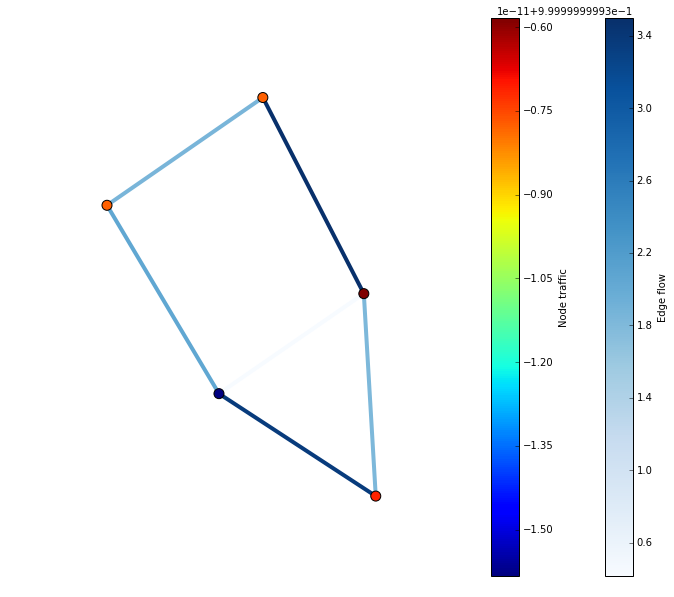

In [8]:
# Plot results.
import networkx as nx

G=nx.Graph()
G.add_nodes_from(range(n))
G.add_edges_from(edges)

print("Nodes of graph: ")
print(G.nodes())
print("Edges of graph: ")
print(G.edges())

# Plot the result.
plt.figure(figsize=(12,10))
pos=nx.spring_layout(G)
node_colors = cvx.diag(T).value.A1.tolist()
nodes = nx.draw_networkx_nodes(G,pos,node_color=node_colors, with_labels=False,
                               node_size=100, node_cmap=plt.cm.Reds)
edge_colors = cvx.sum_entries(F, 0).value.A1.tolist()
edges = nx.draw_networkx_edges(G,pos,edge_color=edge_colors,width=4,
                               edge_cmap=plt.cm.Blues, arrows=True)
plt.colorbar(edges, label='Edge flow')
plt.colorbar(nodes, label='Node traffic')
plt.axis('off')
plt.show()